In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import linkpred
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from events import events
%matplotlib inline

In [2]:
repos = pd.read_csv('../data/processed/2015-01-01/repos_2015-01-02.csv')

In [3]:
repos.head()

,repo_id,repo_name,CheckRunEvent,CheckSuiteEvent,CommitCommentEvent,ContentReferenceEvent,CreateEvent,DeleteEvent,DeployKeyEvent,DeploymentEvent,...,RepositoryEvent,RepositoryImportEvent,RepositoryVulnerabilityAlertEvent,SecurityAdvisoryEvent,StarEvent,StatusEvent,TeamEvent,TeamAddEvent,WatchEvent,WatchEventFuture
0,27,rubinius/rubinius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
1,28,mojombo/god,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,68,macournoyer/thin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,144,mojombo/chronic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,426,haml/haml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


In [4]:
triplets = pd.read_csv('../data/processed/2015-01-01/triplets.csv')

In [5]:
triplets.head()

,user_id,user_name,event_type,repo_id,repo_name
0,9152315,davidjhulse,PushEvent,28635890,davidjhulse/davesbingrewardsbot
1,5581438,jmoon018,PushEvent,26392647,jmoon018/rshell-unit-tester
2,6352424,christoferpeterson,CreateEvent,28677542,christoferpeterson/Vadek
3,66577,JakeWharton,PushEvent,5152285,square/okhttp
4,9221683,git4ruby,PushEvent,28520835,git4ruby/movie_review1


In [6]:
triplets = triplets[triplets.event_type == 'WatchEvent']

In [7]:
triplets.shape

(21939, 5)

In [8]:
#Make nx.Graph object for star event
#Add edges   
G = nx.from_pandas_edgelist(triplets, 
                            source = 'user_id', 
                            target = 'repo_id', 
                            create_using = nx.Graph())

#Make node attributes (node_type, name, number of edges)
for repo_id in triplets['repo_id'].unique().tolist():
    G.add_node(repo_id, node_type = 'repository', name = repos[repos.repo_id == repo_id]['repo_name'].iloc[0])
for node in G.nodes:
    G.nodes[node]['num_stars'] = G.degree[node]


In [ ]:
simrank = linkpred.predictors.SimRank(G, excluded=G.edges())
simrank_results = simrank.predict(c=0.5)

In [13]:
simrank

In [9]:
eigenvector_centralities = nx.eigenvector_centrality(G)
degree_centralities = nx.degree_centrality(G)
# betweenness_centralities = nx.betweenness_centrality(G)
# closeness_centralities = nx.closeness_centrality(G)


In [12]:
def get_total_neighbor_centrality(node, centrality_dict):
    if node not in centrality_dict:
        return 0
    return np.sum([centrality_dict[neighbor] for neighbor in G.neighbors(node)])

In [13]:
repos['eigenvector_centrality'] = repos['repo_id'].apply(lambda x: eigenvector_centralities[x] if x in eigenvector_centralities else 0)

repos['degree_centrality'] = repos['repo_id'].apply(lambda x: degree_centralities[x] if x in degree_centralities else 0)
repos['users_total_degree_centrality'] = repos['repo_id'].apply(get_total_neighbor_centrality, args = (degree_centralities, ))

# repos['betweenness_centrality'] = repos['repo_id'].apply(lambda x: betweenness_centralities[x])
# repos['closeness_centrality'] = repos['repo_id'].apply(lambda x: closeness_centralities[x])

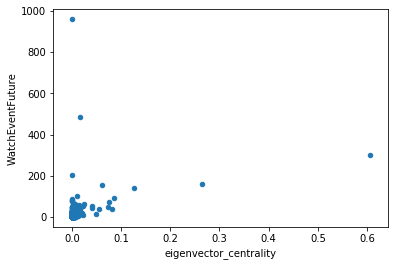

In [14]:
repos.plot.scatter(x = 'eigenvector_centrality', y =  'WatchEventFuture')

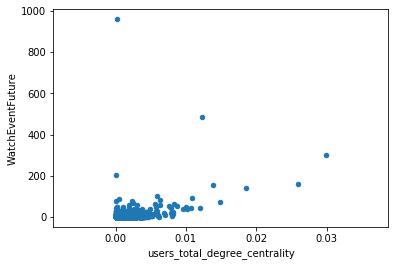

In [15]:
repos.plot.scatter(x = 'users_total_degree_centrality', y =  'WatchEventFuture')

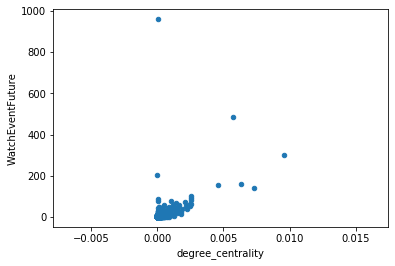

In [16]:
repos.plot.scatter(x = 'degree_centrality', y =  'WatchEventFuture')

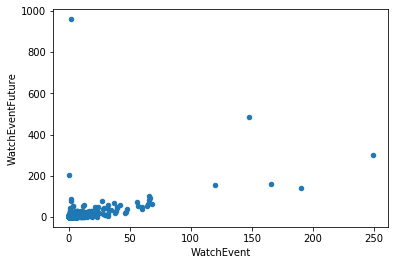

In [17]:
repos.plot.scatter(x = 'WatchEvent', y =  'WatchEventFuture')

In [18]:
non_star_events = events.copy()
non_star_events.remove('WatchEvent')

In [19]:
response = 'WatchEventFuture'
features = events + ['eigenvector_centrality', 'degree_centrality', 'users_total_degree_centrality']
data = repos

In [20]:
train, test = train_test_split(data, random_state = 3)


X_train = train[features]
y_train = train[response].values
X_test = test[features]
y_test = test[response].values

In [21]:
train_mean = y_train.mean()
mean_squared_error(y_train, train_mean * np.ones(len(y_train))), mean_squared_error(y_test, train_mean * np.ones(len(y_test)))

(29.494390138371134, 4.920987448812398)

In [22]:
r2_score(y_test, train_mean * np.ones(len(y_test)))

-3.7336541129251444e-05

In [23]:
#Guess is previous value
mean_squared_error(y_train, X_train['WatchEvent']), mean_squared_error(y_test, X_test['WatchEvent'])

(22.8749298484727, 1.5472310744994289)

In [24]:
r2_score(y_test, X_test['WatchEvent'])

0.6855735035191988

In [25]:
ols_model = LinearRegression().fit(X_train, y_train)
# ols_model.score(X_test, y_test)
mean_squared_error(y_train, ols_model.predict(X_train)), mean_squared_error(y_test, ols_model.predict(X_test))

(22.31247573753615, 2.6021180111008304)

In [26]:
ols_model.score(X_train, y_train)

0.24350103077708918

In [27]:
ols_model.score(X_test, y_test)

0.4712006091755064

In [28]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
lasso_model = Lasso().fit(X_train_sc, y_train)
# ols_model.score(X_test, y_test)
mean_squared_error(y_train, lasso_model.predict(X_train_sc)), mean_squared_error(y_test, lasso_model.predict(X_test_sc))

(23.506003802568152, 1.5079174070671557)

In [29]:
lasso_model.score(X_test_sc, y_test)

0.6935627812155121

In [34]:
gb_model = GradientBoostingRegressor().fit(X_train, y_train)
# gb_model.score(X_test, y_test)
mean_squared_error(y_train, gb_model.predict(X_train)), mean_squared_error(y_test, gb_model.predict(X_test))

(3.854869153257636, 2.2987955278862686)

In [35]:
rf_model = RandomForestRegressor().fit(X_train, y_train)
# gb_model.score(X_test, y_test)
mean_squared_error(y_train, rf_model.predict(X_train)), mean_squared_error(y_test, rf_model.predict(X_test))

/anaconda3/envs/mit/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(5.892602079815881, 4.526205749702771)

In [36]:
gb_model.score(X_train, y_train)


0.8693016151487536

In [37]:
gb_model.score(X_test, y_test)

0.5328414508525435

In [38]:
ridge_model = Ridge().fit(X_train, y_train)
# ols_model.score(X_test, y_test)
mean_squared_error(y_train, ridge_model.predict(X_train)), mean_squared_error(y_test, ridge_model.predict(X_test))

(22.480291029957126, 2.273977765310757)

In [39]:
feature_importances = pd.DataFrame((X_train.columns, gb_model.feature_importances_)).T
feature_importances.columns =  ['feature', 'importance']
feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)
feature_importances

,feature,importance
36,PushEvent,0.539657
51,users_total_degree_centrality,0.139041
49,eigenvector_centrality,0.127018
50,degree_centrality,0.0945021
48,WatchEvent,0.0881828
4,CreateEvent,0.00375911
18,IssueCommentEvent,0.00275738
11,ForkEvent,0.00267716
33,PullRequestEvent,0.00156378
19,IssuesEvent,0.000705881
